In [1]:
import os, sklearn, pandas, numpy as np
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
import keras
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Reshape, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model

Using TensorFlow backend.


In [3]:
# custom scripts
import config # params, constants
import data, models # functions that mutate outr data
from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'labels' = pandas.df('img_name','breed')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


# Prepare dataset
amt should be either 50, 100, 150, 200 etc...

In [4]:
# some img mutation functions

def replace(v1,v2):
    return v2

def add(v1,v2):
    # mean of r,g,b
    return np.mean([v1,v2] ,axis=0)
    # return v1 + np.minimum(v1, v2) / 2

def overlay(v1,v2):
    # add smallest element values
    intermediate = np.minimum(v1, v2)
    return v1 + intermediate # np.minimum(v1,v2)

In [5]:
def random_colored(dims=50):
    img = np.random.random([dims,dims,3])
    # reduce the 'complexity'
    img /= 10
    # increase the bias (per image)
    brightness = 1.5
    color_mutation = np.random.random(3) * brightness
    img *= [[color_mutation for _ in range(dims)] for _ in range(dims)]
    #         img *= [ np.random.random([3]) for _ in range(dims)]
    # brightness
    img *= np.random.random()
    # scale back
    img *= 10
    img = np.clip(img,0,1)
    return img


def random_pos(img):
    # random (x,y) in image
    return np.random.random([2]) * img.shape[0:2]


def add_random(img,f,dims=50):
    # function to mutate an image by adding a small matrix with noise
    # f() can be add/minimum/maximum
    size = 10 
    size = 1 + int(dims * np.random.random() ** 2)
    (x,y) = random_pos(img)
    x = int(round(x))
    y = int(round(y))
    xs = np.clip(np.arange(x,x + size), 0, dims - 1)
    ys = np.clip(np.arange(y,y + size), 0, dims - 1)
    img_ = random_colored(size)
    for i,x in enumerate(xs): 
        for j,y in enumerate(ys):
            img[x,y] = f(img[x,y],img_[i,j])
    return img

 
def random(amt=10,dims=50):
    result = []
    for _ in range(amt):
        img = random_colored(dims)
        for _ in range(np.random.randint(0,10)):
            img = add_random(img,replace,dims)
        result.append(img)
    return np.stack(result)

In [29]:
def gen_labels_random(amt_labels, amt_classes=9):
    return [int((np.random.random() * amt_classes) ) for _ in range(amt_labels)]

def gen_labels(amt_labels, amt_classes=9):
    # beware of a large number of classes
    return [ int(x_train[i].mean() * 10) for i in range(x_train.shape[0]) ]

In [6]:
amt = 3
dims = 50
# x_train = np.random.random([amt,dims,dims,3])
x_train = random(amt,dims)
x_test = np.random.random([amt,dims,dims,3])
y_train = gen_labels(amt)
# [int((np.random.random() * 9) ) for _ in range(amt)]
# y_train = [ int(x_train[i].mean() * 10) for i in range(x_train.shape[0]) ]
y_test = [int((np.random.random() * 9) ) for _ in range(amt)]

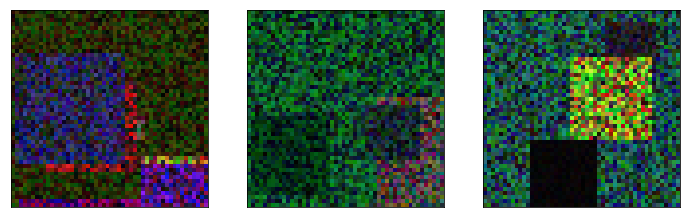

In [7]:
plot.multiple(x_train)

### Prepare the labels

Encode the labels to one-hot vectors

In [8]:
# int-labels => one-hot vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('n labels:',y_train[0].shape)
print(y_train.shape)
y_train[0]

n labels: (9,)
(3, 9)


array([0., 0., 0., 0., 0., 0., 1., 0., 0.])

# Train a Sequential model (keras)

In [9]:
n_samples = x_train.shape[0] # = length of the list of images (matrices)
input_shape = x_train.shape[1:] # = shape of an individual image (matrix)
output_length = (y_train[0]).shape[0] # = length of an individual label
print('n samples:',n_samples)
print('shape:', input_shape)
print('output length:', output_length)

n samples: 3
shape: (50, 50, 3)
output length: 9


## Setup encoders

In [10]:
print(input_shape)
hidden_size = 2 # 2

input_ = Input(shape=input_shape)

x = Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=input_shape)(input_)
# 1/2
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(hidden_size)(x)

(50, 50, 3)


In [11]:
encoder = Model(input_, x)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 4)         112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 8)         520       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        2064      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 16)          0         
__________

## Setup Decoder

In [12]:
# output_shape should be equal to input_shape
input_shape

(50, 50, 3)

In [13]:
encoded = Input(shape=(hidden_size,))

x = Dense(128)(encoded) # (None, 128)   
x = Reshape((4,4,8))(x) # (None, 4, 4, 8)  

x = UpSampling2D((8, 8))(x) # (None, 32, 32, 8)
x = Conv2D(4, (8, 8), activation='relu')(x) # (None, 25, 25, 4)
x = UpSampling2D((2, 2))(x) # (None, 100, 100, 4)
x = Conv2D(3, (1, 1), activation='relu')(x) # (None, 50, 50, 3) 

# go from 50x50 to input_shape[0:2] (=150x150)
a1 = round(input_shape[0] / 50)
a2 = round(input_shape[1] / 50)
param_a = (a1,a2) # (3,3)
print('param_a:',param_a)

x = UpSampling2D(param_a)(x) 

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(encoded, decoded)

decoder.summary()

param_a: (1, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 4)         2052      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 50, 50, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 3)         15   

## Auto-encoder

In [14]:
auto = Model(input_, decoder(encoder(input_)))
auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 4266      
_________________________________________________________________
model_2 (Model)              (None, 50, 50, 3)         2535      
Total params: 6,801
Trainable params: 6,801
Non-trainable params: 0
_________________________________________________________________


### Loss function
Train with binary cross-entropy (each pixel is seen as a probability).

Training data (pixel values) must be normalized to [0:1]

In [15]:
auto.compile(optimizer='adam', loss='binary_crossentropy')

## Train model

In [16]:
# Compute a batch size
batch_size = 128
# n epochs = n iterations over all the training data
epochs = 900

In [17]:
x_train.shape

(3, 50, 50, 3)

In [18]:
# no validation is needed for the autoencoder, as the goal is to reconstruct the data as good as possible
auto.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/900
3/3 [==============================] - 1s 286ms/step - loss: 0.6940
Epoch 2/900
3/3 [==============================] - 0s 5ms/step - loss: 0.6924
Epoch 3/900
3/3 [==============================] - 0s 5ms/step - loss: 0.6907
Epoch 4/900
3/3 [==============================] - 0s 5ms/step - loss: 0.6884
Epoch 5/900
3/3 [==============================] - 0s 5ms/step - loss: 0.6852
Epoch 6/900
3/3 [==============================] - 0s 6ms/step - loss: 0.6811
Epoch 7/900
3/3 [==============================] - 0s 5ms/step - loss: 0.6763
Epoch 8/900
3/3 [==============================] - 0s 7ms/step - loss: 0.6709
Epoch 9/900
3/3 [==============================] - 0s 6ms/step - loss: 0.6654
Epoch 10/900
3/3 [==============================] - 0s 6ms/step - loss: 0.6608
Epoch 11/900
3/3 [==============================] - 0s 5ms/step - loss: 0.6583
Epoch 12/900
3/3 [==============================] - 0s 6ms/step - loss: 0.6571
Epoch 13/900
3/3 [==============================] - 0s 5ms/

Epoch 105/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4618
Epoch 106/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4617
Epoch 107/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4615
Epoch 108/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4614
Epoch 109/900
3/3 [==============================] - 0s 7ms/step - loss: 0.4613
Epoch 110/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4612
Epoch 111/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4611
Epoch 112/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4610
Epoch 113/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4609
Epoch 114/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4608
Epoch 115/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4607
Epoch 116/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4606
Epoch 117/900
3/3 [=====================

Epoch 208/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4539
Epoch 209/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4538
Epoch 210/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4538
Epoch 211/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4537
Epoch 212/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4537
Epoch 213/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4536
Epoch 214/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4535
Epoch 215/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4535
Epoch 216/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4534
Epoch 217/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4533
Epoch 218/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4533
Epoch 219/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4532
Epoch 220/900
3/3 [=====================

Epoch 311/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4478
Epoch 312/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4478
Epoch 313/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4477
Epoch 314/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4477
Epoch 315/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4476
Epoch 316/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4476
Epoch 317/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4476
Epoch 318/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4475
Epoch 319/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4475
Epoch 320/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4475
Epoch 321/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4474
Epoch 322/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4474
Epoch 323/900
3/3 [=====================

Epoch 414/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4436
Epoch 415/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4435
Epoch 416/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4434
Epoch 417/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4434
Epoch 418/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4434
Epoch 419/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4433
Epoch 420/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4433
Epoch 421/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4432
Epoch 422/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4431
Epoch 423/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4431
Epoch 424/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4431
Epoch 425/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4430
Epoch 426/900
3/3 [=====================

Epoch 517/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4402
Epoch 518/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4402
Epoch 519/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4401
Epoch 520/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4401
Epoch 521/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4401
Epoch 522/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4401
Epoch 523/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4401
Epoch 524/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4401
Epoch 525/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4400
Epoch 526/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4400
Epoch 527/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4400
Epoch 528/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4400
Epoch 529/900
3/3 [=====================

Epoch 620/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4386
Epoch 621/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4386
Epoch 622/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4386
Epoch 623/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4386
Epoch 624/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4386
Epoch 625/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4385
Epoch 626/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4385
Epoch 627/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4385
Epoch 628/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4385
Epoch 629/900
3/3 [==============================] - 0s 6ms/step - loss: 0.4385
Epoch 630/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4385
Epoch 631/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4385
Epoch 632/900
3/3 [=====================

Epoch 723/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4378
Epoch 724/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 725/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 726/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 727/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 728/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 729/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 730/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 731/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 732/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 733/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4377
Epoch 734/900
3/3 [==============================] - 0s 5ms/step - loss: 0.4376
Epoch 735/900
3/3 [=====================

Epoch 826/900
3/3 [==============================] - 0s 8ms/step - loss: 0.4371
Epoch 827/900
3/3 [==============================] - 0s 8ms/step - loss: 0.4371
Epoch 828/900
3/3 [==============================] - 0s 8ms/step - loss: 0.4371
Epoch 829/900
3/3 [==============================] - 0s 7ms/step - loss: 0.4371
Epoch 830/900
3/3 [==============================] - 0s 7ms/step - loss: 0.4371
Epoch 831/900
3/3 [==============================] - 0s 9ms/step - loss: 0.4371
Epoch 832/900
3/3 [==============================] - 0s 7ms/step - loss: 0.4372
Epoch 833/900
3/3 [==============================] - 0s 8ms/step - loss: 0.4372
Epoch 834/900
3/3 [==============================] - 0s 8ms/step - loss: 0.4372
Epoch 835/900
3/3 [==============================] - 0s 7ms/step - loss: 0.4372
Epoch 836/900
3/3 [==============================] - 0s 8ms/step - loss: 0.4372
Epoch 837/900
3/3 [==============================] - 0s 8ms/step - loss: 0.4371
Epoch 838/900
3/3 [=====================

## Generate new images

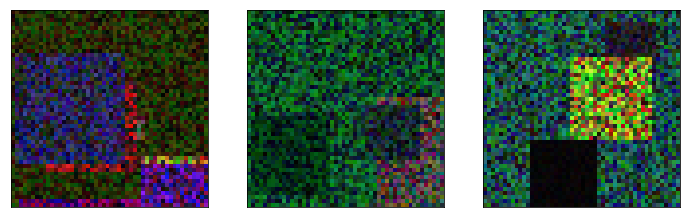

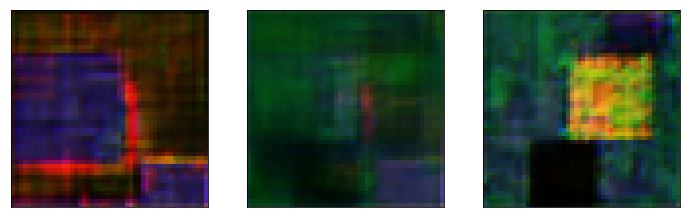

In [36]:
# old data
inputs1 = x_train[:10, :, :, :]
outputs1 = auto.predict(inputs1)

plot.multiple(inputs1[:10])
plot.multiple(outputs1[:10])

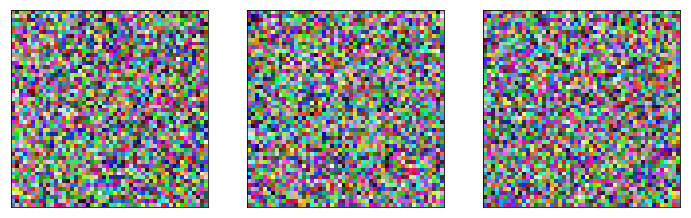

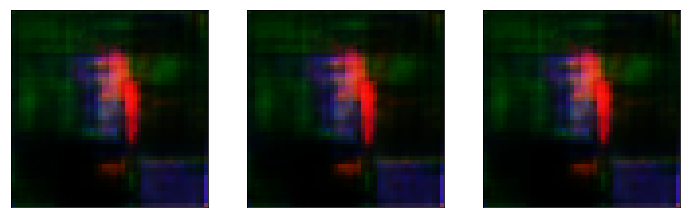

In [20]:
# new data
inputs = x_test[:10, :, :, :]
outputs = auto.predict(inputs)

plot.multiple(inputs[:10])
plot.multiple(outputs[:10])

In [21]:
# investigate the range of the 'hidden' layer
inputs2 = x_test[:10, :, :, :]
outputs2 = encoder.predict(inputs2)
print(outputs2)

[[ 6.454445  -6.506621 ]
 [ 7.3559275 -6.259385 ]
 [ 6.8303814 -6.6751356]]


Use random values as input for the decoder

10 [[72.89339904544809, 13.991256740129431], [2.4127348728470817, 63.8053423510752], [53.57585594232535, 28.97826202021213], [71.83803378520312, 77.07314374959985], [49.57523934224203, 0.9960502158629524], [95.70818256096317, 41.26479351618922], [72.63792531842395, 0.8804067539772805], [1.7428161059050233, 24.812766306171667], [45.25269373744861, 23.095628954996812], [25.214529690294196, 0.07517476092825359]]


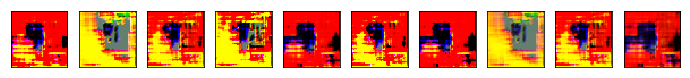

In [35]:
# samples = np.array([ [3,1.8] ])
def random(scale=100):
    # :scale = random value in range [-scale:scale]
    # use ** 2 to skew the distribution
    return scale * ((np.random.random() - 0.5) * 2) ** 2

samples = []
for x in range(10):
    # sample = np.random.random([hidden_size]) * scale * ((np.random.random() - 0.5) * 2) ** 2
    sample = [random() for _ in range(hidden_size)]
    samples.append(sample)

print(len(samples), samples)
samples = np.stack(samples)
results = decoder.predict(samples)
plot.multiple(results)

Note that high values produce complex results

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


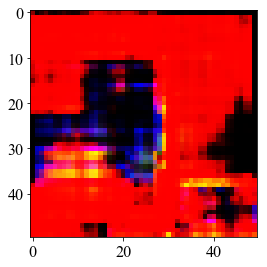

In [23]:
skimage.io.imshow(results[8])

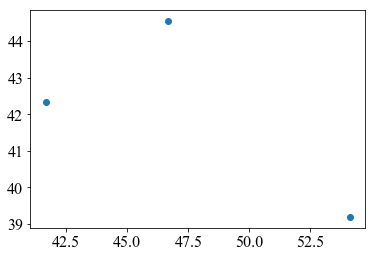

In [24]:
num = 10

inputs3 = x_test[:num, :, :, :]
latent = encoder.predict(inputs3) ** 2

# plt.scatter(latent[:,0], latent[:,1], c=y_test[:num], alpha=0.1)
plt.scatter(latent[:,0],latent[:,1])

## Retrain (recursively)

In [38]:
epochs = 10
for _ in range(10):
    x_result = auto.predict(x_train)
    auto.fit(x_result, x_result, epochs=epochs, batch_size=batch_size);
    x_result = auto.predict(x_result)

Epoch 1/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3984
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3910
Epoch 3/100
3/3 [==============================] - 0s 13ms/step - loss: 0.4058
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 0.3900
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.3945
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 0.3922
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3879
Epoch 8/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3824
Epoch 9/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3840
Epoch 10/100
3/3 [==============================] - 0s 12ms/step - loss: 0.3831
Epoch 11/100
3/3 [==============================] - 0s 15ms/step - loss: 0.3781
Epoch 12/100
3/3 [==============================] - 0s 15ms/step - loss: 0.3799
Epoch 13/100
3/3 [==============================]

Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3129
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.3141
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3091
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 0.3101
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3097
Epoch 9/100
3/3 [==============================] - 0s 10ms/step - loss: 0.3096
Epoch 10/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3080
Epoch 11/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3071
Epoch 12/100
3/3 [==============================] - 0s 8ms/step - loss: 0.3083
Epoch 13/100
3/3 [==============================] - 0s 7ms/step - loss: 0.3069
Epoch 14/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3063
Epoch 15/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3057
Epoch 16/100
3/3 [==============================] - 0s 

Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2617
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2655
Epoch 10/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2614
Epoch 11/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2630
Epoch 12/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2612
Epoch 13/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2617
Epoch 14/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2608
Epoch 15/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2602
Epoch 16/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2603
Epoch 17/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2604
Epoch 18/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2601
Epoch 19/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2595
Epoch 20/100
3/3 [==============================] -

Epoch 12/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2351
Epoch 13/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2350
Epoch 14/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2342
Epoch 15/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2347
Epoch 16/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2340
Epoch 17/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2341
Epoch 18/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2339
Epoch 19/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2338
Epoch 20/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2335
Epoch 21/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2335
Epoch 22/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2335
Epoch 23/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2332
Epoch 24/100
3/3 [==============================] -

Epoch 16/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2190
Epoch 17/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2186
Epoch 18/100
3/3 [==============================] - 0s 16ms/step - loss: 0.2190
Epoch 19/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2186
Epoch 20/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2188
Epoch 21/100
3/3 [==============================] - 0s 13ms/step - loss: 0.2187
Epoch 22/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2186
Epoch 23/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2187
Epoch 24/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2185
Epoch 25/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2187
Epoch 26/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2185
Epoch 27/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2186
Epoch 28/100
3/3 [===========================

3/3 [==============================] - 0s 12ms/step - loss: 0.2094
Epoch 20/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2095
Epoch 21/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2094
Epoch 22/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2094
Epoch 23/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2094
Epoch 24/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2093
Epoch 25/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2094
Epoch 26/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2094
Epoch 27/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2093
Epoch 28/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2094
Epoch 29/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2093
Epoch 30/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2093
Epoch 31/100
3/3 [==============================] - 0s 9ms/ste

Epoch 23/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2048
Epoch 24/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2048
Epoch 25/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2048
Epoch 26/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2048
Epoch 27/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2048
Epoch 28/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2048
Epoch 29/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2048
Epoch 30/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2048
Epoch 31/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2048
Epoch 32/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2047
Epoch 33/100
3/3 [==============================] - 0s 12ms/step - loss: 0.2048
Epoch 34/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2048
Epoch 35/100
3/3 [===========================

Epoch 27/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 28/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 29/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 30/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 31/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 32/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2010
Epoch 33/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2010
Epoch 34/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2010
Epoch 35/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2010
Epoch 36/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2010
Epoch 37/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2010
Epoch 38/100
3/3 [==============================] - 0s 7ms/step - loss: 0.2010
Epoch 39/100
3/3 [==============================] - 

Epoch 31/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 32/100
3/3 [==============================] - 0s 7ms/step - loss: 0.1983
Epoch 33/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1983
Epoch 34/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 35/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1983
Epoch 36/100
3/3 [==============================] - 0s 7ms/step - loss: 0.1983
Epoch 37/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1983
Epoch 38/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 39/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1983
Epoch 40/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 41/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1983
Epoch 42/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1983
Epoch 43/100
3/3 [=========================

Epoch 34/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1962
Epoch 35/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1962
Epoch 36/100
3/3 [==============================] - 0s 11ms/step - loss: 0.1962
Epoch 37/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1963
Epoch 38/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1963
Epoch 39/100
3/3 [==============================] - 0s 12ms/step - loss: 0.1963
Epoch 40/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1962
Epoch 41/100
3/3 [==============================] - 0s 7ms/step - loss: 0.1962
Epoch 42/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1962
Epoch 43/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1962
Epoch 44/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1962
Epoch 45/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1962
Epoch 46/100
3/3 [=============================

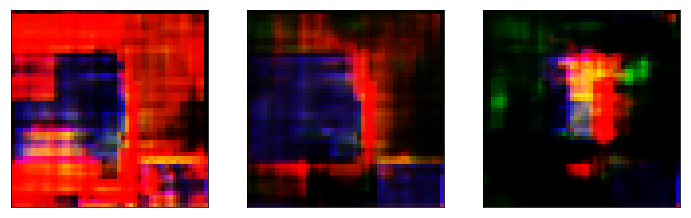

In [39]:
plot.multiple(x_result[:10])

10 [[32.961209169334985, 0.4099600711197713], [67.72741148292265, 83.13994506710472], [39.98837238312, 29.079484675599915], [75.90560984165539, 16.867891552968846], [5.143906928606077, 29.748362380667043], [98.45859974646565, 1.2782906342241747], [0.34689847356824455, 2.4028599262781296], [93.15322327767032, 75.05367879480019], [2.8792125251808693, 7.36588943588459], [23.359888298034434, 6.626756723774624]]


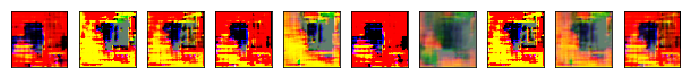

In [42]:
# with random data

samples = []
for x in range(10):
    # sample = np.random.random([hidden_size]) * scale * ((np.random.random() - 0.5) * 2) ** 2
    sample = [random() for _ in range(hidden_size)]
    samples.append(sample)

samples = np.stack(samples)
results = decoder.predict(samples)
plot.multiple(results)